線形回帰を行うときの重要な仮定は

* 残差が独立同分布になっている

である(より正しくは回帰係数の推定量の分布が多変量正規分布で近似されること).  よく言われている条件

* 残差が正規分布に従うこと

は必須の条件ではない.  残差が正規分布に従うことは必要ないし, 残差の分布が正規分布に従っていても i.i.d. になっていなければ線形回帰の適用は不適切であると考えられる.

もちろん, 残差が正規分布以外の分布のi.i.d.になっている場合には, 誤差が大きくなることはありえるので要注意である.

残差が正規分布以外の分布のi.i.d.になっているように見える場合には, 観測していない独立変数に $y$ が非線形に依存している可能性を疑う必要があるかもしれない.

In [1]:
using Distributions
using KernelDensity
using LinearAlgebra
dot2(x) = dot(x, x)
using Optim
using Random
using StatsFuns
using StatsPlots
default(fmt=:png, titlefontsize=10, tickfontsize=6, guidefontsize=8, legendfontsize=8)

In [2]:
Random.seed!(4649373)

disty(x,a,b,c,d,s,t) = MixtureModel(
    [Normal(a + b*x, exp(s)), Normal(c + d*x , exp(t))],
    fill(1/2, 2))

function plot_mixedcase(; n=10^3, distx=Normal(0,2), disty=disty,
        w_true=Float64[2, 1, 2, 3, log(1), log(1)])
    x = rand(distx, n)
    y = @. rand(disty(x, w_true...))
    X = x .^ (0:1)'
    @show β̂ = X \ y
    ŷ = X * β̂

    P1 = scatter(x, y; label="data: (x, y)", msc=:auto, alpha=0.5, ms=2)
    plot!(x -> [1,x]'*β̂; label="simple regression line: (x, ŷ)", lw=1.5)

    P2 = scatter(x, y - ŷ; label="residual error: (x, y - ŷ)", msc=:auto, alpha=0.5, ms=2)
    hline!([0]; label="", lw=1.5)

    P3 = stephist(y - ŷ; norm=true, label="histogram of residual error y - ŷ")
    plot!(fit(Normal, y - ŷ); label="normal approximation")
    
    negloglik(a, b, c, d, s, t) = -logsumexp(logpdf(disty(x,a,b,c,d,s,t), y) for (x, y) in zip(x, y))
    o = optimize(w -> negloglik(w..., 0, 0), w_true[1:4], LBFGS())
    @show o
    @show w_true[1:4]
    @show â, b̂, ĉ, d̂ = o.minimizer

    Q1 = scatter(x, y; label="", msc=:auto, alpha=0.5, ms=2)
    plot!(x -> â + b̂*x; label="regression line 1", ls=:dash, lw=1.5, c=2)
    plot!(x -> ĉ + d̂*x; label="regression line 2", ls=:dashdot, lw=1.5, c=2)

    plot(P1, P2, P3, Q1; size=(800, 600), legend=:outertop, layout=(2, 2))
end

plot_mixedcase (generic function with 1 method)

β̂ = X \ y = [2.0800931906770157, 2.089289168325404]
o =  * Status: success

 * Candidate solution
    Final objective value:     -5.209981e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.14e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.87e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.12e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.82e-14 ≰ 0.0e+00
    |g(x)|                 = 7.21e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    7
    f(x) calls:    21
    ∇f(x) calls:   21

w_true[1:4] = [2.0, 1.0, 2.0, 3.0]
(â, b̂, ĉ, d̂) = o.minimizer = [1.9662548727016729, 1.1184506093120639, 2.1637189931479712, 2.941148498248878]


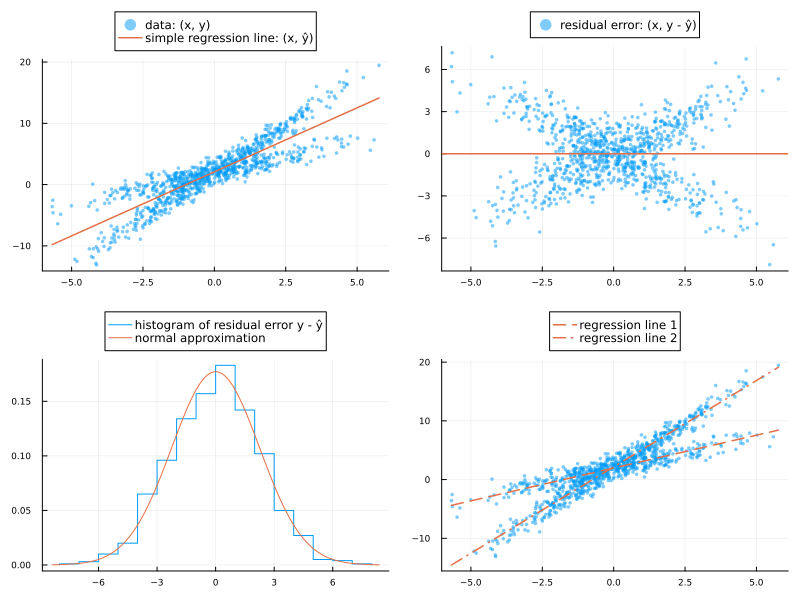

In [3]:
plot_mixedcase()

以下は残差が非正規分布になっている場合.

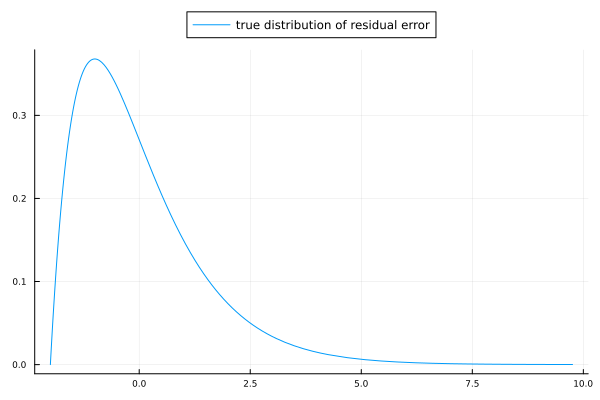

In [4]:
_distu = Gamma(2, 1)
distu = _distu - mean(_distu)

plot(distu; label="true distribution of residual error", legend=:outertop)

In [5]:
function plot_ols(; n = 1000,
        distx = Normal(0, 2),
        a = 1.0, b = 1.0, F = x -> a+b*x,
        _distu = Gamma(2, 1), distu = _distu - mean(_distu),
        qthreshold = 0.01,
        xlim=quantile.(distx, (qthreshold, 1-qthreshold)))
    x = rand(distx, n)
    y = @. F(x) + rand(distu)

    @show distx
    @show distu
    @show n
    println()
    
    X = x .^ (0:1)'
    @show β̂_true = [a, b]
    @show β̂ = X \ y
    println()
    
    ŷ = X * β̂
    @show σ_true = √var(distu)
    @show √(dot2(y - ŷ)/(n - size(X, 2)))
    
    P0 = plot(distu; label="", c=3, ls=:dashdot)
    title!("true distribution of residuals")
    
    P1 = scatter(x, y; label="data: (x, y)", msc=:auto, alpha=0.5, ms=2)
    plot!(x -> [1,x]'*β̂; label="simple regression line: (x, ŷ)", lw=1.5)

    P2 = scatter(x, y - ŷ; label="", msc=:auto, alpha=0.5, ms=2)
    hline!([0]; label="", lw=1.5)
    plot!(xguide="x")
    title!("residuals: (x, y - ŷ)")

    P3 = stephist(y - ŷ; norm=true, label="histogram of residuals y - ŷ")
    plot!(fit(Normal, y - ŷ); label="normal approximation", ls=:dash)
    plot!(distu; label="true distribution of residuals", ls=:dashdot)

    ylim = quantile.((y - ŷ,), (qthreshold, 1-qthreshold))
    ikx = InterpKDE(kde(x))
    ikxy = InterpKDE(kde((x, y-ŷ)))
    f(x, y) = pdf(ikxy, x, y) / pdf(ikx, x)
    xs = range(xlim..., 20)
    ys = range(ylim..., 20)

    P4 = heatmap(xs, ys, f; colorbar=false)
    hline!([0]; label="", c=:cyan)
    title!("KDE of conditional distribution of residuals")
    
    perm = sortperm(x)
    P5 = scatter(1:n, (y - ŷ)[perm]; label="", msc=:auto, alpha=0.5, ms=2)
    hline!([0]; label="", lw=1.5)
    plot!(xguide="rank of x")
    title!("residuals: (rank of x, y - ŷ)")

    plot(P0, P1, P2, P3, P5, P4; size=(800, 900), legend=:outertop, layout=(3, 2))
end

plot_ols (generic function with 1 method)

In [ ]:
plot_ols()

In [ ]:
plot_ols(; n=100)

In [ ]:
plot_ols(; F = x -> 1 + x + 0.3x^2, n=1000)

In [ ]:
plot_ols(; F = x -> 1 + x + 0.3x^2, n=100)

残差の分布がi.i.d.になっていれば、残差が正規分布にしたがっていない場合であっても, 回帰係数の推定量 $\hat\beta$ の分布は2変量正規分布で近似される.  以下でそのことを確認しよう.

In [ ]:
function sim(distx, a, b, distu, n; L=10^5)
    tmpx = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    tmpu = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    tmpy = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    tmpX = [Matrix{Float64}(undef, n, 2) for _ in 1:Threads.nthreads()]
    β̂ = [Vector{Float64}(undef, 2) for _ in 1:L]
    Threads.@threads for i in 1:L
        tid = Threads.threadid()
        x = rand!(distx, tmpx[tid])
        u = rand!(distu, tmpu[tid])
        y = @. tmpy[tid] = a + b*x + u
        tmpX[tid][:,1] .= 1
        tmpX[tid][:,2] .= x
        X = tmpX[tid]
        β̂[i] = X \ y
    end
    β̂
end

# 回帰係数の分布は以下の分布に漸近する.
function mvnormalapprox_true(; n = 1000,
        distx = Normal(0, 2),
        a = 1.0, b = 1.0,
        _distu = Gamma(2, 1), distu = _distu - mean(_distu))
    μx = mean(distx)
    σx² = var(distx)
    σ² = var(distu)
    μ_true = [a, b]
    Σ_true = σ²/(n*σx²)*[σx²+μx^2 -μx; -μx 1]
    MvNormal(μ_true, Σ_true)
end

In [ ]:
function plot_betahat(; n = 1000,
        distx = Normal(0, 2),
        a = 1.0, b = 1.0,
        _distu = Gamma(2, 1), distu = _distu - mean(_distu),
        L=10^5)
    @show distx
    @show distu
    @show n
    println()
    
    β̂ = sim(distx, a, b, distu, n; L)
    @show mvnormalapprox_true(; n, distx, a, b, _distu, distu)
    @show fit(MvNormal, stack(β̂))

    β̂₀, β̂₁ = getindex.(β̂, 1)[begin:min(end,10000)], getindex.(β̂, 2)[begin:min(end,10000)]
    Q1 = scatter(β̂₀, β̂₁; label="", msc=:auto, alpha=0.5, ms=1)
    title!("distribution of regression coefficients")
    Q2 = stephist(β̂₀; norm=true, label="")
    plot!(fit(Normal, β̂₀); label="normal approx.", ls=:dash)
    title!("distribution of first coefficients")
    Q3 = stephist(β̂₁; norm=true, label="")
    plot!(fit(Normal, β̂₁); label="normal approx.", ls=:dash)
    title!("distribution of second coefficients")

    plot(Q1, Q3, Q2; size=(800, 600))
end

In [ ]:
plot_betahat(; n=1000)

以上は標本サイズが $n=1000$ の場合である. 標本サイズが $n=10, 20$ 程度だと正規分布近似の誤差が見える程度になる.

In [ ]:
plot_betahat(; n=10)

In [ ]:
plot_betahat(; n=20)

In [ ]:
plot_betahat(; n=40)

In [ ]:
plot_betahat(; n=100)

このようにi.i.d.の残差の分布が正規分布でなくても, 標本サイズが十分に大きければ, 回帰係数の分布は多変量正規分布で近似される.

In [ ]:
plot_betahat(; distx=Normal(2, 2), n=10)

In [ ]:
plot_betahat(; distx=Normal(2, 2), n=20)

In [ ]:
plot_betahat(; distx=Normal(2, 2), n=40)

In [ ]:
plot_betahat(; distx=Normal(2, 2), n=100)